# 1. Import

In [1]:
!pip install joblib

In [2]:
import sklearn
import pandas as pd
from sklearn.preprocessing import RobustScaler
import umap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import joblib
from torch.utils.data import DataLoader


In [3]:
%load_ext autoreload
%autoreload 2

Last time we're able to "softly" label data and engineer some useful features for the modeling part. Now let's use the data for modelling!!

# 2. Load data

In [4]:
with open("engineered_data.csv","r") as f:
    df = pd.read_csv(f)

In [5]:
Y = df["female_flag"].to_numpy()
X = df.drop(["female_flag","customer_id"], axis=1).to_numpy()

# Stratified for unbalanced class
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)

scaler = RobustScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Save scaler
joblib.dump(scaler,"robust_scaler.pkl")
scaler_load = joblib.load("robust_scaler.pkl")

# 3. Simple visualization

In [7]:
reducer = umap.UMAP()
reducer.fit(X_train_scaled)

UMAP(dens_frac=0.0, dens_lambda=0.0)

In [8]:
X_train_plot = reducer.transform(X_train_scaled)

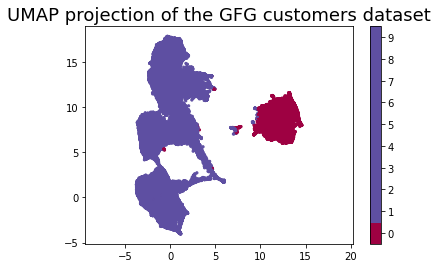

In [9]:
plt.scatter(X_train_plot [:, 0], X_train_plot[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the GFG customers dataset', fontsize=18);

Pretty neat, they are kinda linearly separable, but data in each class also has very large deviation from the mean. This raw feature might not be enough for a simple linear model to be robust to new dataset, hence we need another type of model.

# 4. Modeling

In [13]:
from models.tripletnet import TripletNet
from models.embeddingnet import EmbeddingNet
from utils.dataset import TripletDataset
import pytorch_lightning as pl  

In [14]:
train_dataset = TripletDataset(X_train, y_train)
test_dataset = TripletDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset,batch_size=32)
test_dataloader = DataLoader(test_dataset,batch_size=32)

In [16]:
embedding_net = EmbeddingNet(input_dim=X_train.shape[1])
triplet_net = TripletNet(embedding_net)
trainer = pl.Trainer(gpus=0, precision=16, limit_train_batches=0.5)
trainer.fit(triplet_net, train_dataloader, test_dataloader)

MisconfigurationException: You have asked for native AMP on CPU, but AMP is only available on GPU.

In [19]:
import torch
torch.cuda.is_available() 

False